# winter 2022 week03

## goals:

reload the data
run util/load_data.py convert_all() function -- which loads everything and converts it to parquet

## todo
- ~add PIPA to list of interesting ones (57 -> 58)~
- figure out how to get the thing to run faster (try to just use geopoints_sampled in analyze)
- final count of reduced fishing
- run the analyze thing over those 7/8
- make those charts of in/out fishing effort of individual ships for those 7/8
- make pictures of before/after fishing effort of individual ships for those 7/8 (could use consistent colors)

THEN:
- make table of (low, low), (low, high), (high, low), (high, high). etc. of the 58
- make table of (?, low), (?, high) of all the other ones

AND THEN:
- compare to the paper about 5 MPAs
- email Dan to show him everything
- title: what can GFW data tell us about the true protection of MPA?
- two effective scenarios: (high, low) and (low, low) ~= (?, low)


## notes:



In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd /Users/brendan/Documents/mpa_project/gfw_research

/Users/brendan/Documents/mpa_project/gfw_research


In [20]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
from shapely import ops
import pretty_html_table
import cProfile

import util

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

In [5]:
DATA_PATH = "/Users/brendan/Documents/mpa_project/gfw_research/data/"
FILENAME = "mpatlas_20201223_clean/mpatlas_20201223_clean.shp"

import util

#mpas = geopandas.read_file(DATA_PATH + FILENAME)
# util.load_mpatlas_mpas()
mpas = geopandas.read_parquet("data/mpas/mpatlas.parquet")

In [6]:
no_take = mpas[(mpas['no_take']=='All') & (mpas['implemente'])]

<AxesSubplot:>

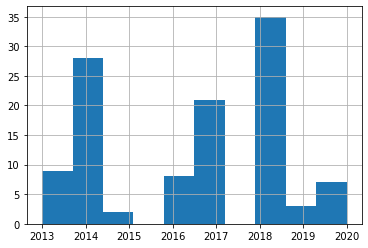

In [7]:
no_take[no_take['status_yea'] > 2012]['status_yea'].hist()


In [8]:
def load_year(year):
    year = str(year)
    print(f'\r reading year {year}', end='')
    return pandas.read_parquet("data/points/" + year + ".parquet")

In [9]:
points_by_year = {
    year : load_year(year)
    for year in range(2012, 2021)
}

 reading year 2020

In [10]:
# sample the points here before converting to geo
# use the sampled points to find the mmsi that are interesting
# only then should we get all of the points of relevent mmsi

SAMPLE_RATIO = 100
points_sampled = []
for year, points in points_by_year.items():
    print(f'\rsampling {str(year)}... ', end='')
    points_sampled.append(points.sample(frac=1/SAMPLE_RATIO))
print('done.')
points_sampled = pandas.concat(points_sampled)
print("converting to geo...  ", end='')
geopoints_sampled = util.convert_to_geo(points_sampled, box=True)
print("done.")


sampling 2020... done.
converting to geo...  done.


In [71]:
of_interest_frame = no_take[
    ((no_take['status_yea'] >= 2012) | (no_take['implementa'] > '2012-01-01')) & no_take['implemente']]
of_interest = [
    (555512002, 'Phoenix Island Protected Area', '2015-01-01')
]
# for i, row in no_take[no_take['status_yea'] > 2012].iterrows():
for i, row in of_interest_frame.iterrows():
    date = row['implementa']
    if date is None:
        date = str(row['status_yea'])
    of_interest.append(
        (row['wdpa_id'], row['name'], date)
    )

# natural park of the coral sea - nature reserve
# has too much activity or something, will come back to this
# print(of_interest.pop(4))
# print(of_interest.pop(3))

In [72]:
of_interest

[(555512002, 'Phoenix Island Protected Area', '2015-01-01'),
 (555714969, 'Lebyazh`i ostrova', '2018'),
 (555711347, 'Vostok Finskogo zaliva (Ingermanlandskij)', '2017'),
 (555708108, 'Medvezh`i ostrova', '2020'),
 (555705576, 'Ko Kam Yai Marine Fisheries Reserved Area', '2016'),
 (555705568, 'Niue Moana Mahu Marine Protected Area', '2020'),
 (555703726, "D'Arros to Poivre Atolls (Marine) National Park", '2020'),
 (555703725, "D'Arros Atoll (Marine) National Park", '2020'),
 (555703724, 'Bird Island (Ile aux Vaches) (Marine) National Park', '2020'),
 (555703723, 'Amirantes South (Marine) National Park', '2020'),
 (555703541, 'Jebel Ali Wetland Sanctuary', '2018'),
 (555703534, 'Khor Al Muzahmi', '2018'),
 (555548008, 'Batemans', '2018'),
 (555655703, 'Stellar Sea Lion', '2014-01-01'),
 (555629385,
  'Revillagigedo - Zona Núcleo/Uso Restringido Turismo',
  '2018-11-30'),
 (0, 'Natural Park of the Coral Sea - Nature Reserve', '2018-08-01'),
 (0, 'Natural Park of the Coral Sea - Wildernes

In [ ]:


if False:
    wdpa_id, name, date = of_interest[0]
    print(name)
    mpa = mpas[mpas['wdpa_id'] == wdpa_id]
    # util.analyze_mpa(geopoints_sampled, points_by_year, mpa, date, plot_pre_post=False, verbose=True)

    # cProfile.run("util.analyze_mpa(geopoints_sampled, points_by_year, mpa, date, plot_pre_post=False)")

In [59]:
tables = pandas.DataFrame()
summed_tables = pandas.DataFrame()
j = 0
for wdpa_id, name, date in of_interest:
    j += 1
    print(f'\r{j}/{len(of_interest)} {name}                                                      ', end='')
    mpa = mpas[mpas['wdpa_id'] == wdpa_id]
    returned = util.analyze_mpa(geopoints_sampled, points_by_year, mpa, date, plot_pre_post=False, verbose=True)
    if returned:
        table, pre, post, points = returned
        table.insert(0, 'name', name)
        table.insert(1, 'wdpa_id', wdpa_id)
        tables = tables.append(table)
        
        summed = table.groupby('name').aggregate({
            'name': 'first',
            'wdpa_id': 'first',
            'mmsi': 'count',
            'in_pre': 'sum',
            'out_pre': 'sum',
            'in_post': 'sum',
            'out_post': 'sum'})
        summed_tables = summed_tables.append(summed)
    else:
        pass
        # summed_tables = summed_tables.append({'name': mpa.iloc[0]['name']}, ignore_index=True)

1/114 Phoenix Island Protected Area                                                      running sjoin... 
found 648 sampled points in the mpa from 132 ships
found 2239476 points of mpa ships
2/114 Lebyazh`i ostrova                                                      running sjoin... 
found 0 sampled points in the mpa from 0 ships
exiting: found no points
3/114 Vostok Finskogo zaliva (Ingermanlandskij)                                                      running sjoin... 
found 0 sampled points in the mpa from 0 ships
exiting: found no points
4/114 Medvezh`i ostrova                                                      running sjoin... 
found 0 sampled points in the mpa from 0 ships
exiting: found no points
5/114 Ko Kam Yai Marine Fisheries Reserved Area                                                      running sjoin... 
found 0 sampled points in the mpa from 0 ships
exiting: found no points
6/114 Niue Moana Mahu Marine Protected Area                                                 

TypeError: Invalid comparison between dtype=datetime64[ns] and NoneType

In [ ]:
summed_tables